In [ ]:
#default_exp audio.augment
#default_cls_lvl 3

# Data Augmentation for Audio

> Transforms to apply data augmentation to AudioSpectrograms and Signals

In [ ]:
#export
from local.torch_basics import *
from local.test import *
from local.data.all import *
from local.vision.core import *
from local.notebook.showdoc import show_doc
from local.audio.core import *
from local.learner import *
from local.vision.models.xresnet import *
from local.metrics import *

In [ ]:
# export
import torch.nn
from torch import stack, zeros_like as t0, ones_like as t1
from torch.distributions.bernoulli import Bernoulli
from librosa.effects import split
from dataclasses import asdict
from scipy.signal import resample_poly
import librosa

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
x = AudioGetter("", recurse=True, folders=None)
files = x(p)
aud = AudioItem.create(files[0])

In [ ]:
voice_mel_cfg = {'n_fft':2560, 'f_max':22050., 'n_mels':128, 'hop_length':256}
a2s = AudioToSpec(n_fft = 1024, hop_length=256)

In [ ]:
original_spec = a2s(aud)

In [ ]:
type(original_spec[0])

local.audio.core.AudioSpectrogram

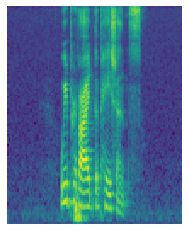

In [ ]:
original_spec.show()

In [ ]:
original_spec.n_fft

1024

## Spectrogram Transforms

###  Crop Time, pad_spectro(internal)

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong><br> 
    1. Should this be extending RandomTransform? <br>
    2. In spectrogram when we pad with mean value we mess up normalization by altering std dev, how can we use fill values that dont mess things up<br></div>


In [ ]:
#export
def CropTime(duration, pad_mode="zeros"):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Random crops full spectrogram to be length specified in ms by crop_duration'''
        sg = spectro.clone()
        sr, hop= spectro.sr, spectro.hop_length
        w_crop = int((sr*duration)/(1000*hop))
        w_sg   = sg.shape[-1]
        if   w_sg <  w_crop: 
            sg_pad = _tfm_pad_spectro(sg, w_crop, pad_mode=pad_mode)
            return AudioSpectrogram.create(sg_pad, settings=spectro.settings)
        elif w_sg == w_crop: return sg
        else:
            crop_start = random.randint(0, int(w_sg - w_crop))
            sg_crop = sg[:,:,crop_start:crop_start+w_crop]
            sg_crop.sample_start = int(crop_start*hop)
            sg_crop.sample_end   = sg_crop.sample_start + int(duration*sr)
            return AudioSpectrogram.create(sg_crop, settings=spectro.settings)
    return _inner

In [ ]:
def _tfm_pad_spectro(sg, width, pad_mode="zeros"):
    '''Pad spectrogram to specified width, using specified pad mode'''
    c,y,x = sg.shape
    pad_m = pad_mode.lower()
    if pad_m in ["zeros", "zeros-after"]:
        zeros_front = random.randint(0, width-x) if pad_m == "zeros" else 0
        pad_front = torch.zeros((c,y, zeros_front))
        pad_back = torch.zeros((c,y, width-x-zeros_front))
        return AudioSpectrogram(torch.cat((pad_front, sg, pad_back), 2))
    elif pad_m == "repeat":
        repeats = width//x + 1
        return sg.repeat(1,1,repeats)[:,:,:width]
    else:
        raise ValueError(f"pad_mode {pad_m} not currently supported, only 'zeros', 'zeros-after', or 'repeat'")

if width of the spectrogram is less than width of the cropping window -> pad
if they are equal -> return unaltered
if width of spectro > width of cropping window, randomly select the cropping window

In [ ]:
crop_1000ms = CropTime(1000)
crop_2000ms = CropTime(2000)
crop_5000ms = CropTime(5000, pad_mode="zeros-after")
print(f"Audio is {aud.duration} seconds")

Audio is 3.28 seconds


In [ ]:
s1 = crop_1000ms(original_spec)
s1.show()

AttributeError: 'AudioSpectrogram' object has no attribute 'settings'

In [ ]:
s2 = crop_2000ms(original_spec)
s2.show()

AttributeError: 'AudioSpectrogram' object has no attribute 'settings'

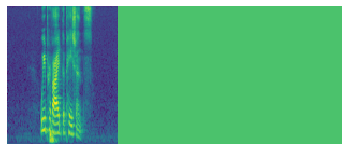

In [ ]:
s5 = crop_5000ms(original_spec)
s5.show()

In [ ]:
original_spec.settings


{'transformer': Sequential(
   (0): MelSpectrogram(
     (spectrogram): Spectrogram()
     (mel_scale): MelScale()
   )
   (1): AmplitudeToDB()
 ),
 'to_db': True,
 'mel': True,
 'n_fft': 1024,
 'hop_length': 256,
 'sr': 16000,
 'nchannels': 1,
 'path': PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')}

In [ ]:
original_spec.shape

torch.Size([1, 128, 103])

In [ ]:
s1.shape, s2.shape, s5.shape

(torch.Size([1, 128, 62]),
 torch.Size([1, 128, 125]),
 torch.Size([1, 128, 312]))

<div class = "alert alert-block alert-info"> If we wanted to we could make a class for these transforms that keeps the masked portion as state so that we could write a decodes method to go back to the original</div>


<div class = "alert alert-block alert-info"> Is it better to use nonlocal here to be able to assign the value of start in the closure?</div>


### SpecAugment

In [ ]:
#export
def MaskFreq(num_masks=1, size=20, start=None, val=None, **kwargs):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        '''Google SpecAugment time masking from https://arxiv.org/abs/1904.08779.'''
        start_ = start
        sg = spectro.clone()
        channel_mean = sg.contiguous().view(sg.size(0), -1).mean(-1)[:,None,None]
        mask_val = channel_mean if val is None else val
        c, y, x = sg.shape
        for _ in range(num_masks):
            mask = torch.ones(size, x) * mask_val    
            if start_ is None: start_= random.randint(0, y-size)
            if not 0 <= start_ <= y-size:
                raise ValueError(f"Start value '{start_}' out of range for AudioSpectrogram of shape {sg.shape}")
            sg[:,start_:start_+size,:] = mask
            start_ = None
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

<div class = "alert alert-block alert-info"> Passing around the settings manually is already fairly clunky, but is especially bad when we have to do it twice when MaskTime hands off to MaskFrequency. We should maybe make a copy of the AudioSpectrogram and then alter the tensor for it's sg rather than cloning out the sg and then building a new object at the end</div>


In [ ]:
#export
def MaskTime(num_masks=1, size=20, start=None, val=None, **kwargs):
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        sg = spectro.clone()
        sg = torch.einsum('...ij->...ji', sg)
        sg = AudioSpectrogram.create(sg, settings=spectro.settings)
        sg = MaskFreq(num_masks, size, start, val, **kwargs)(sg)
        return AudioSpectrogram.create(torch.einsum('...ij->...ji', sg), settings=spectro.settings)
    return _inner

In [ ]:
freq_mask = MaskFreq()

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 10.5 ms


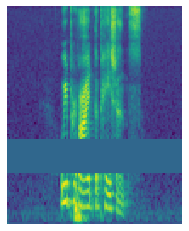

In [ ]:
%%time
freq_mask(original_spec).show()

CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 10.9 ms


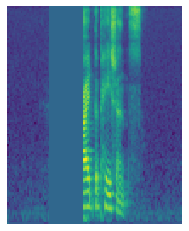

In [ ]:
%%time
time_mask = MaskTime()
time_mask(original_spec).show()

## SG Roll

In [ ]:
def TfmRoll(max_shift_pct=0.7, direction=0, **kwargs):
    '''Shifts spectrogram along x-axis wrapping around to other side'''
    if int(direction) not in [-1, 0, 1]: 
        raise ValueError("Direction must be -1(left) 0(bidirectional) or 1(right)")
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        if len(spectro.shape) < 2:
            raise Exception('Cannot apply spectrogram rolling to a signal')
        nonlocal direction
        direction = random.choice([-1, 1]) if direction == 0 else direction
        sg = spectro.clone()
        c, height, width = sg.shape
        roll_by = int(width*random.random()*max_shift_pct*direction)
        sg = sg.roll(roll_by, dims=2)
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
roller = TfmRoll()

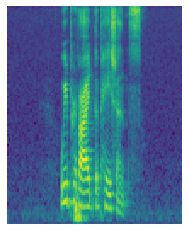

In [ ]:
original_spec.show()

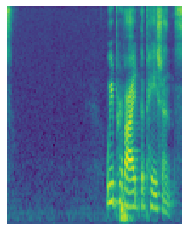

In [ ]:
roller(original_spec).show()

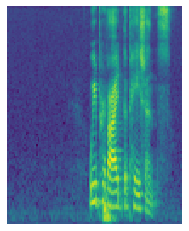

In [ ]:
roller(original_spec).show()

## Delta/Accelerate 

In [ ]:
#export
def _torchdelta(mel:AudioSpectrogram, order=1, width=9):
    '''Converts to numpy, takes delta and converts back to torch, needs torchification'''
    if(mel.shape[1] < width): 
        raise ValueError(f'''Delta not possible with current settings, inputs must be wider than 
        {width} columns, try setting max_to_pad to a larger value to ensure a minimum width''')
    return AudioSpectrogram(torch.from_numpy(librosa.feature.delta(mel.numpy(), order=order, width=width)))

In [ ]:
def Delta(width=9):
    td = partial(_torchdelta, width=width)
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        new_channels = [torch.stack([c, td(c, order=1), td(c, order=2)]) for c in spectro]
        return AudioSpectrogram.create(torch.cat(new_channels), settings=spectro.settings)
    return _inner

In [ ]:
delta = Delta()

In [ ]:
d = delta(original_spec)


<div class = "alert alert-block alert-info"><strong>TO-DO:</strong> Test delta as part of a pipeline to make sure SpecAugment/roll/interpolate...etc are working on multichannel</div>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


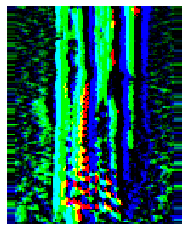

In [ ]:
d.show()

In [ ]:
d.shape

torch.Size([3, 128, 103])

## Image resizing

<div class = "alert alert-block alert-info"> This should probably be refactored to use visions size transform since it already exists</div>


In [ ]:
def TfmResize(size, interp_mode="bilinear", **kwargs):
    '''Temporary fix to allow image resizing transform'''
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        nonlocal size
        if isinstance(size, int): size = (size, size)
        sg = spectro.clone()
        c,y,x = sg.shape
        sg = F.interpolate(sg.unsqueeze(0), size=size, mode=interp_mode, align_corners=False).squeeze(0)
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
resizer = TfmResize(224)

In [ ]:
original_spec.shape

torch.Size([1, 128, 103])

In [ ]:
resizer(original_spec).shape


torch.Size([1, 224, 224])

## Pipeline testing

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong> Test delta as part of a pipeline to make sure SpecAugment/roll/interpolate...etc are working on multichannel</div>


<div class = "alert alert-block alert-info"><strong>TO-DO:</strong> Allow beginner to choose height and width of output spectrogram and have settings adjust accordingly</div>


In [ ]:
files

(#3842) [/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0005_us_m0005_00282.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00432.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00054.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0004_us_m0004_00110.wav,/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0003_us_m0003_00180.wav...]

In [ ]:
oa = OpenAudio(files); oa

OpenAudio: True {'object': 'encodes'} {'object': 'decodes'}

In [ ]:
sg_cfg = MelSpectrogramConfig(hop_length=256, n_fft=2048)
pipe = Pipeline([oa, AudioToSpec.from_cfg(sg_cfg), CropTime(1000), MaskTime(num_masks=2, size=4), MaskFreq(val=42)], as_item=True)

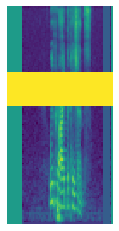

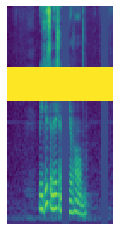

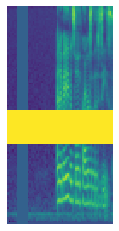

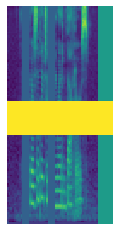

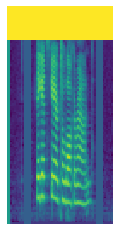

In [ ]:
for i in range(5): pipe.show(pipe(i))

## Signal Transforms

In [ ]:
#export
def CropSignal(duration, pad_mode="zeros"):
    def _inner(ai: AudioItem)->AudioItem:
        '''Crops signal to be length specified in ms by duration, padding if needed'''
        sig = ai.sig.clone()
        orig_samples = ai.nsamples
        crop_samples = int((duration/1000)*ai.sr)
        if orig_samples < crop_samples: 
            sig_pad = _tfm_pad_signal(sig, crop_samples, pad_mode=pad_mode)
            return AudioItem((sig_pad, ai.sr, ai.path))
        elif orig_samples == crop_samples: return AudioItem((sig, ai.sr, ai.path))
        else:
            crop_start = random.randint(0, int(orig_samples-crop_samples))
            sig_crop = sig[:,crop_start:crop_start+crop_samples]
            return AudioItem((sig_crop, ai.sr, ai.path))
    return _inner

In [ ]:
def _tfm_pad_signal(sig, width, pad_mode="zeros"):
    '''Pad spectrogram to specified width, using specified pad mode'''
    c,x = sig.shape
    pad_m = pad_mode.lower()
    if pad_m in ["zeros", "zeros-after"]:
        zeros_front = random.randint(0, width-x) if pad_m == "zeros" else 0
        pad_front = torch.zeros((c, zeros_front))
        pad_back = torch.zeros((c, width-x-zeros_front))
        return torch.cat((pad_front, sig, pad_back), 1)
    elif pad_m == "repeat":
        repeats = width//x + 1
        return sig.repeat(1,repeats)[:,:width]
    else:
        raise ValueError(f"pad_mode {pad_m} not currently supported, only 'zeros', 'zeros-after', or 'repeat'")

In [ ]:
aud

(tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
          -6.1035e-05, -1.8311e-04]]),
 16000,
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav'))

In [ ]:
cropsig_1000ms = CropSignal(1000)
cropsig_2000ms = CropSignal(2000)
cropsig_5000ms = CropSignal(5000, pad_mode="zeros-after")
print(f"Audio is {aud.duration} seconds")

Audio is 3.28 seconds


In [ ]:
aud1s = cropsig_1000ms(aud)
aud2s = cropsig_2000ms(aud)
aud5s = cropsig_5000ms(aud)

In [ ]:
aud1s.nsamples, aud2s.nsamples, aud5s.nsamples

(16000, 32000, 80000)

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


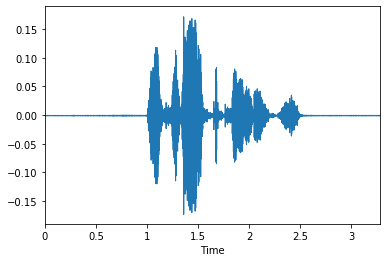

In [ ]:
aud.show()

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


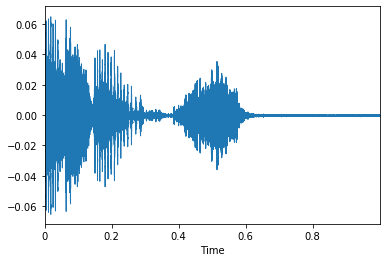

In [ ]:
aud1s.show()

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


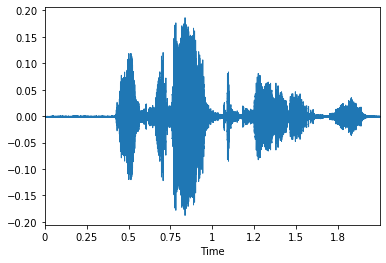

In [ ]:
aud2s.show()

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


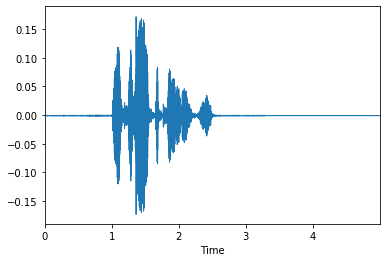

In [ ]:
aud5s.show()

# Preprocessing functions

##  Remove Silence

In [ ]:
#export
def _merge_splits(splits, pad):
    clip_end = splits[-1][1]
    merged = []
    i=0
    while i < len(splits):
        start = splits[i][0]
        while splits[i][1] < clip_end and splits[i][1] + pad >= splits[i+1][0] - pad:
            i += 1
        end = splits[i][1]
        merged.append(np.array([max(start-pad, 0), min(end+pad, clip_end)]))
        i+=1
    return np.stack(merged)

def RemoveSilence(remove_type, threshold=20, pad_ms=20):
    def _inner(ai:AudioItem)->AudioItem:
        '''Split signal at points of silence greater than 2*pad_ms '''
        if remove_type is None: return ai
        padding = int(pad_ms/1000*ai.sr)
        if(padding > ai.nsamples): return ai
        actual = ai.sig.clone()
        splits = split(actual.numpy(), top_db=threshold, hop_length=padding)
        if remove_type == "split":
            sig =  [actual[:,(max(a-padding,0)):(min(b+padding,ai.nsamples))] 
                    for (a, b) in _merge_splits(splits, padding)]
        elif remove_type == "trim":
            sig = [actual[:,(max(splits[0, 0]-padding,0)):splits[-1, -1]+padding]]
        elif remove_type == "all":
            sig = [torch.cat([actual[:,(max(a-padding,0)):(min(b+padding,ai.nsamples))] 
                              for (a, b) in _merge_splits(splits, padding)], dim=1)]
        else: 
            raise ValueError(f"Valid options for silence removal are None, 'split', 'trim', 'all' not '{cfg.remove_silence}'.")
        return AudioItem((*sig, ai.sr, ai.path))
    return _inner

<div class = "alert alert-block alert-info"><strong>TO-DO:</strong><br/> 
    1. Fix display of multiple audios, plots are messed up<br/>
    2. Add in longer clips (whale) and do more extensive testing<br/></div>


File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


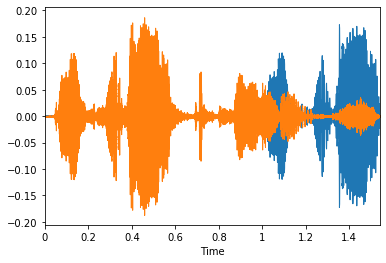

In [ ]:
silence_audio = RemoveSilence("trim", threshold=20, pad_ms=20)(aud)
a2s = AudioToSpec(n_fft = 1024, hop_length=256)
aud.show()
silence_audio.show()

## Resampling

In [ ]:
#export
def Resample(sr_new):
    def _inner(ai:AudioItem)->AudioItem:
        '''Resample using faster polyphase technique and avoiding FFT computation'''
        if(ai.sr == sr_new): return AudioItem(ai)
        sig_np = ai.sig.numpy()
        sr_gcd = math.gcd(ai.sr, sr_new)
        resampled = resample_poly(sig_np, int(sr_new/sr_gcd), int(ai.sr/sr_gcd), axis=-1)
        resampled = resampled.astype(np.float32)
        return AudioItem((torch.from_numpy(resampled), sr_new, ai.path))
    return _inner

In [ ]:
no_resample_needed = Resample(aud.sr)(aud)
assert(not no_resample_needed is aud)
test_eq(aud.sr, no_resample_needed.sr)
test_eq(aud.sig, no_resample_needed.sig)

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


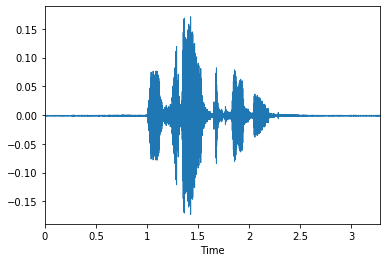

In [ ]:
very_downsampled = Resample(4000)(aud)
orig_samples = aud.nsamples
down_samples = very_downsampled.nsamples
test_eq(down_samples, orig_samples//(aud.sr/very_downsampled.sr))
very_downsampled.show()

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


CPU times: user 24.1 s, sys: 1.06 s, total: 25.2 s
Wall time: 6.29 s


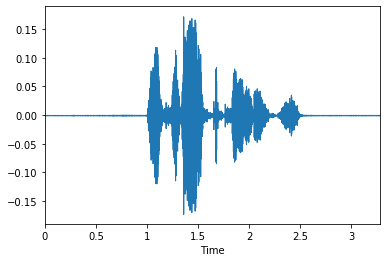

In [ ]:
%%time
# polyphase does bad with random resample rates ~74ms per, but this
# should never happen because of relatively fixed sample rates
# bad == low gcd between old and new sample rate

for i in range(100):
    random_sr = random.randint(16000, 72000)
    random_upsample = Resample(random_sr)(aud)
    num_samples = random_upsample.nsamples
    assert(abs(num_samples-(orig_samples//(aud.sr/random_sr)) <= 1))
no_resample_needed.show()

# End-to-End Example

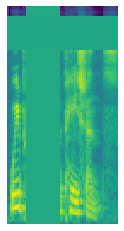

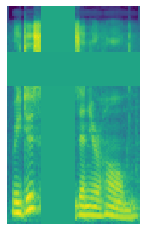

In [ ]:
items = get_audio_files(p)
oa = OpenAudio(items)
preprocesses = [oa, RemoveSilence("trim"), Resample(22050),]
augments = [AudioToSpec(n_fft=1048), MaskTime(), MaskFreq()]
functions = preprocesses + augments
pipe = Pipeline(functions, as_item=True)
for i in range(2): pipe.show(pipe(i))

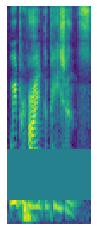

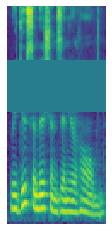

In [ ]:
oa = OpenAudio(items)
preprocesses = [oa, RemoveSilence("trim"), Resample(16000),]
short_hop_mel = MelSpectrogramConfig(hop_length=128, n_fft=1024)
augments = [AudioToSpec.from_cfg(short_hop_mel), MaskFreq(size=30)]
functions = preprocesses + augments
pipe = Pipeline(functions, as_item=True)
for i in range(2): pipe.show(pipe(i))

<div class='alert alert-block alert-warning'><strong>Warning:</strong>By default AudioToSpec will use the default arguments of the specified _GenSpec() function (currently wraps torchaudio.transforms.MelSpectrogram). In that function the defaults are awful, and hop_length defaults to None. We don't currently pass along arguments whose value is None to be stored as attributes of the AudioSpectrogram object, so if no hop_length is specified, CropTime won't work. Not sure the best fix right now so I'm leaving it as an open issue. Likely we will override MelSpectrograms default hop_length, because having a default hop_length is important because without it you cant interpret the x-axis of a spectrogram. The other option is storing a duration attribute directly in the spectrogram. This would allow us to have access to the scale of the x-axis without a hop, and we could avoid the repetition of calculating time duration from hop/sr/samples.

First example below demonstrates the problem. No hop_length is specified for AudioToSpec -> error: AudioSpectrogram object has no attribute hop_length

Second example demonstrates a working version by passing a hop_length
</div>

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


AttributeError: AudioSpectrogram object has no attribute hop_length

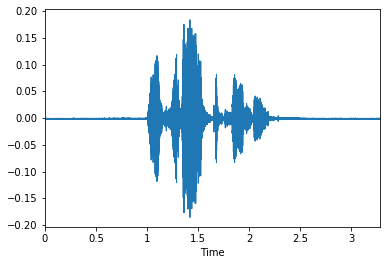

In [ ]:
labeler = lambda x: str(x).split('/')[-1][:5]
tfms = [[AudioItem.create, Resample(8000)], [labeler]]
items = get_audio_files(p)

tds = TfmdDS(items, tfms)
tds.show(tds[0])
tdl = TfmdDL(tds, bs=8, after_item=[AudioToSpec(), CropTime(1000), MaskTime(), MaskFreq()])

File: /home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav


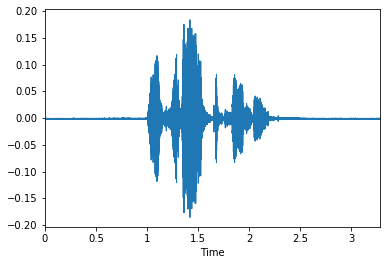

In [ ]:
labeler = lambda x: str(x).split('/')[-1][:5]
tfms = [[AudioItem.create, Resample(8000)], [labeler]]
items = get_audio_files(p)

tfds = TfmdDS(items, tfms)
tfds.show(tfds[0])
bs = 8
tfdl = TfmdDL(tfds, bs=bs, after_item=[AudioToSpec(hop_length=256), CropTime(1000), MaskTime(), MaskFreq()])

In [ ]:
t = tfdl.one_batch()
print(len(t[0]), "tensors with shapes", [ten.shape for ten in t[0]])
print("labels", t[1])

8 tensors with shapes [torch.Size([1, 128, 31]), torch.Size([1, 128, 31]), torch.Size([1, 128, 31]), torch.Size([1, 128, 31]), torch.Size([1, 128, 31]), torch.Size([1, 128, 31]), torch.Size([1, 128, 31]), torch.Size([1, 128, 31])]
labels ('f0004', 'm0002', 'f0003', 'f0001', 'f0005', 'm0005', 'f0005', 'f0005')


<div class = "alert alert-block alert-info"><strong>TO-DO:</strong> `decode_batch` and `show_batch` are causing recursion errors in the following two cells</div>


In [ ]:
#tfdl.show_batch(max_n=4)

In [ ]:
# batch = tfdl.one_batch()
# test_eq(len(batch[0]), bs)
# test_eq(len(batch[1]), bs)
# tfdl.decode_batch(batch)

## Datablock and Basic End to End Training

In [ ]:
auds = DataBlock(ts=(AudioItem, Category), 
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

In [ ]:
cats = [y for _,y in auds.datasource(p)]

In [ ]:
#verify categories are being correctly assigned
min(cats), max(cats)

(0, 9)

<div class = "alert alert-block alert-warning">Because we haven't adjusted the standard learner to handle 1 channel input, we have to just stack the spectrograms to 3 channels using expand to see if we can get an actual end-to-end training example</div>

In [ ]:
def Stack3Channels():
    def _inner(spectro:AudioSpectrogram)->AudioSpectrogram:
        sg = spectro.clone().expand(3, -1, -1)
        return AudioSpectrogram.create(sg, settings=spectro.settings)
    return _inner

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
a2s = AudioToSpec(n_fft = 1024, hop_length=256)
crop_2000ms = CropTime(2000)
tfms = Pipeline([a2s, crop_2000ms, Stack3Channels()], as_item=True)
dbunch = auds.databunch(p, ds_tfms=tfms, bs=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


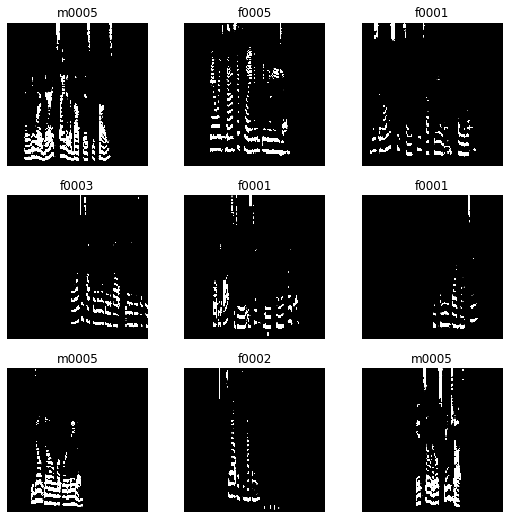

In [ ]:
dbunch.show_batch(max_n=9)

In [ ]:
dbunch.one_batch()[0].shape

torch.Size([64, 3, 128, 125])

In [ ]:
learn = Learner(xresnet18(), 
                dbunch, 
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])

In [ ]:
learn.fit(10, lr=3e-2)

KeyboardInterrupt: 

In [ ]:
# sg_cfg = SpectrogramConfig(hop=256)
# cfg._sr = 16000
# pipe = Pipeline([oa, RemoveSilence(cfg), AudioToSpec(cfg), MaskTime(num_masks=2, size=10), MaskFreq(val=0)], as_item=True)

In [ ]:
# for i in range(1): pipe.show(pipe(i))

## Cropping signal instead of Spectrogram so that we can move on to GPU transforms

In [ ]:
auds = DataBlock(ts=(AudioItem, Category), 
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 get_y=lambda x: str(x).split('/')[-1][:5])

In [ ]:
auds.datasource(p)[0]

((tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.5259e-04,
           -6.1035e-05, -1.8311e-04]]),
  16000,
  PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav')),
 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


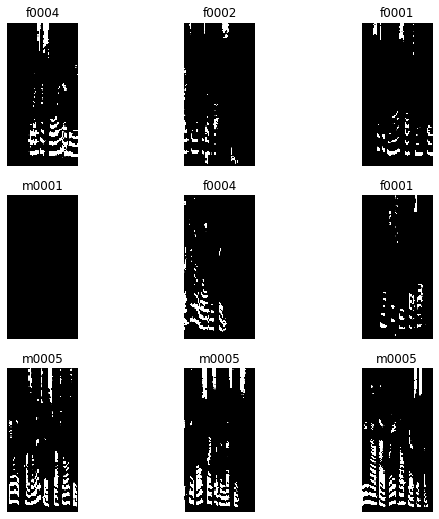

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
cropsig_2000ms = CropSignal(2000)
a2s2 = AudioToSpec(n_fft=1024, hop_length=128)
ds_tfms = Pipeline([cropsig_2000ms, a2s2, Stack3Channels()], as_item=True)
dl_tfms = Pipeline([], as_item=True)
dbunch = auds.databunch(p, ds_tfms=ds_tfms, dl_tfms=dl_tfms, bs=64)
dbunch.show_batch(max_n=9)

<div class = "alert alert-block alert-warning"><strong>Bug: </strong>Cropsig 2000ms is giving us an image that is only 63 pixels wide, crop spectro 2000ms is giving us one that is 125 pixels wide. Odd that it is almost 2x exactly (might be exact)</div>

Let's do math, 2000ms = 2s = 32000 samples @ 16khz. Hop is 256 so expected width is 32000/256 = 125 so the CropTime for spectros is right and the one for signal is wrong by half, why? Earlier testing verified it was cropping to right number of samples 16000/32000/80000 for 1000ms 2000ms 5000ms @ 16khz. If the pipeline is a2s -> CropTime(spectro) it changes when we alter the hop_length of the a2s transform, but it doesn't when we go CropSignal(sig) -> a2s, why? Note that changing the duration for CropSignal does work and change the end images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


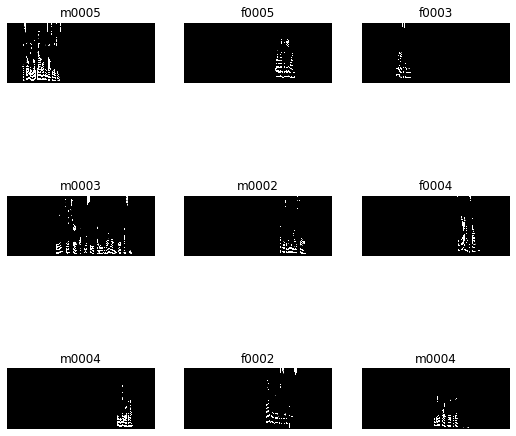

In [ ]:
p = Path('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')
a2s = AudioToSpec(n_fft = 1024, hop_length=64)
cropsig_10000ms = CropSignal(10000)
tfms = Pipeline([cropsig_10000ms, a2s, Stack3Channels()], as_item=True)
dbunch = auds.databunch(p, ds_tfms=tfms, bs=64)
dbunch.show_batch(max_n=9)

In [ ]:
dbunch.one_batch()[0].shape

torch.Size([64, 3, 128, 313])

In [ ]:
learn = Learner(xresnet18(), 
                dbunch, 
                torch.nn.CrossEntropyLoss(), 
                metrics=[accuracy])

In [ ]:
learn.fit(10, lr=3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.891951,1.518864,0.527344,00:04
1,1.124965,1.052567,0.678385,00:04
2,0.878859,0.816636,0.765625,00:04
3,0.727672,0.656250,0.824219,00:04
4,0.635488,0.563640,0.852865,00:04
5,0.565147,0.482565,0.876302,00:04
6,0.495991,0.421092,0.894531,00:04
7,0.449103,0.463987,0.873698,00:04
8,0.416718,0.485305,0.850260,00:04
9,0.373371,0.477935,0.848958,00:04


## Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)